In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pickle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerPatch
import tifffile

plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42


def get_rotation_matrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])


class HandlerCircle(HandlerPatch):
    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        p = patches.Circle((width / 2, height / 2), orig_handle.radius * 3)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def label_obj(pos, s, fg, bg, r, theta, ypad, ax=None):
    from matplotlib.markers import MarkerStyle
    from matplotlib.patheffects import withStroke

    verts = np.array(
        [(2.0322, 0), (4.0649, 4.9746), (2.0322, 3.7942), (0, 4.9746), (2.0322, 0)]
    )
    verts -= verts.mean(axis=0)
    verts @= get_rotation_matrix(-np.pi / 2)
    mat = np.load("data/camera_matrix.npy")

    if ax is None:
        ax = plt.gca()

    pos = mat @ (*pos, 2, 1)
    pos = pos[:2] / pos[2]
    theta = np.deg2rad(theta)
    pos += r * np.cos(theta), r * np.sin(theta)
    marker = MarkerStyle(verts @ get_rotation_matrix(theta + np.pi))
    ax.plot(*pos, marker=marker, markersize=5, c=fg, mew=0)
    text = ax.annotate(
        s,
        pos,
        (0, ypad),
        textcoords="offset points",
        fontsize=6,
        ha="center",
        va="center",
        color=fg,
    )
    text.set_path_effects([withStroke(linewidth=1, foreground=bg)])


def get_fg(im, bg):
    is_bg = np.isclose(im, bg, atol=1).all(axis=2)
    im_alpha = np.ones((*im.shape[:2], 4)) * 255
    im_alpha[:, :, :3] = im
    im_alpha[is_bg, 3] = 0
    im_alpha = im_alpha.astype(np.uint8)
    return im_alpha

In [2]:
spawn_positions = [
    (-1, -1, 0.2),
    (-1, 0, 0.2),
    (-1, 1, 0.2),
    (0, -1, 0.2),
    (0, 0, 0.2),
    (0, 1, 0.2),
    (1, -1, 0.2),
    (1, 0, 0.2),
    (1, 1, 0.2),
]
num_train_steps = 500000
trajectories = []

for spawn_pos in spawn_positions:
    in_path = f"outputs/{num_train_steps}_{spawn_pos[0]}_{spawn_pos[1]}_{spawn_pos[2]}/info_hist.pkl"
    with open(in_path, "rb") as f:
        info_hist = pickle.load(f)
    traj = [np.array(spawn_pos[:2])] + [x["fly_pos"] for x in info_hist[1:]]
    trajectories.append(np.array(traj))

In [3]:
frames = tifffile.imread(
    f"outputs/{num_train_steps}_0_0_{spawn_pos[2]}/bird_eye_frames.tif"
)
bkg = np.median(frames, axis=0).astype(np.uint8)
imgs = [get_fg(frame, bkg) for frame in frames[1::7]]

In [4]:
w0, h0 = 53.863, 29.757
w1, h1 = 35.433, 23.622
target_pos = (15, 0)
obstacle_pos = (7.5, 0)
markersize = 2
c = {"targ": "C1", "obst": "k", "succ": "C0", "fail": "C3"}
labels = ["Odor source", "Obstacle", "Success trials", "Failure trials"]
x = 60
y = 80
dx = 500

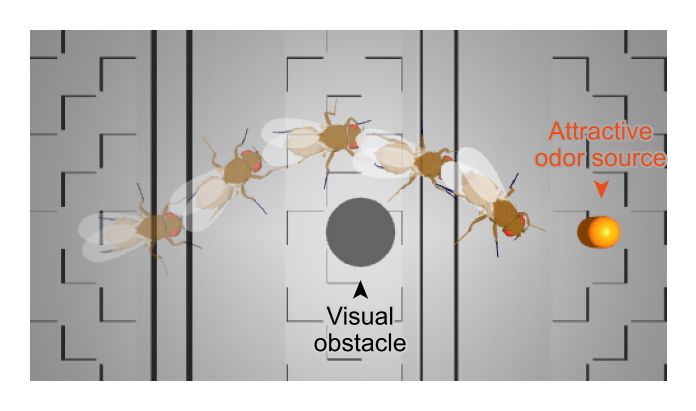

In [5]:
fig, ax = plt.subplots(figsize=(w0 / 25.4, h0 / 25.4), dpi=300)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax.axis("off")
ax.imshow(bkg)

for i, img in enumerate(imgs):
    ax.imshow(img, alpha=(i + 1) / len(imgs) * 0.6 + 0.4)

label_obj(obstacle_pos, "Visual\nobstacle", c["obst"], "lightgray", 45, 90, -10)
label_obj(target_pos, "Attractive\nodor source", "#E94E1B", "darkgray", 35, -90, 10)

ax.set_xlim(x, x + dx)
dy = dx * h0 / w0
ax.set_ylim(y + dy, y)

plt.savefig(
    "outputs/trajectory.pdf",
    bbox_inches="tight",
    pad_inches=0,
    transparent=True,
    dpi=300,
)

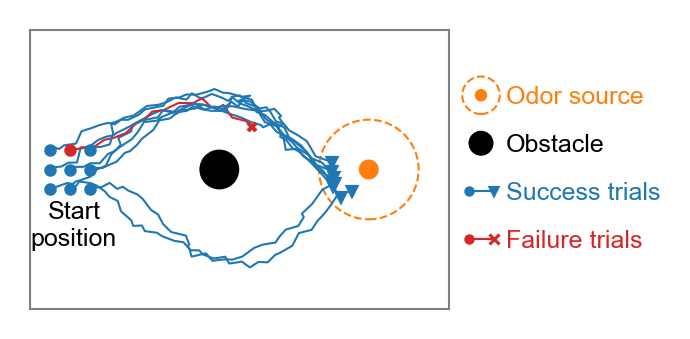

In [6]:
fig, ax = plt.subplots(figsize=(w1 / 25.4, h1 / 25.4), dpi=300)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax.set_xticks([])
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color("#808080")

for traj in trajectories:
    last_pos_dist = np.linalg.norm(traj[-1, :] - np.array([15, 0]))
    if last_pos_dist < 2:
        color = c["succ"]
        end_marker = "v"
    else:
        color = c["fail"]
        end_marker = "x"
    ax.plot(
        [traj[0, 0]],
        traj[0, 1],
        marker="o",
        color=color,
        markersize=markersize,
    )
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.5, color=color)
    ax.plot(
        [traj[-1, 0]],
        traj[-1, 1],
        marker=end_marker,
        color=color,
        markersize=markersize,
    )

target_range = patches.Circle(
    target_pos,
    radius=2.5,
    edgecolor=c["targ"],
    facecolor="none",
    linestyle="--",
    linewidth=0.5,
)
target = patches.Circle(target_pos, radius=0.5, fc=c["targ"], lw=0)
obstacle = patches.Circle(obstacle_pos, radius=1, fc=c["obst"], lw=0)

ax.add_patch(target_range)
ax.add_patch(target)
ax.add_patch(obstacle)
ax.set_aspect("equal")
ax.set_xlim([-2, 19])
ax.set_ylim([-7, 7])
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.2, -1.6, "Start\nposition", ha="center", va="top", fontsize=6)

target_range_small = patches.Circle(
    (15, 0),
    radius=1.5,
    ec=c["targ"],
    fc="none",
    ls="--",
    lw=0.5,
)

handles = [
    (target, target_range_small),
    obstacle,
    Line2D([0], [0], color=c["succ"], lw=0.5),
    Line2D([0], [0], color=c["fail"], lw=0.5, markersize=3),
]

legend = ax.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=6,
    frameon=False,
    borderaxespad=0.8,
    borderpad=0,
    labelcolor=list(c.values()),
    handlelength=1,
    handler_map={patches.Circle: HandlerCircle()},
    labelspacing=1,
    handletextpad=0.5,
)

line2 = legend.get_lines()[-2]
x0, *_, x1 = line2.get_xdata()
y = line2.get_ydata()[0]

trans2 = line2.get_transform()
fig.add_artist(
    Line2D([x0], [y], c=c["succ"], lw=0.5, marker="o", markersize=1.5, transform=trans2)
)
fig.add_artist(
    Line2D([x1], [y], c=c["succ"], lw=0.5, marker="v", markersize=1.5, transform=trans2)
)

line3 = legend.get_lines()[-1]
x0, *_, x1 = line3.get_xdata()
y = line3.get_ydata()[0]
trans3 = line3.get_transform()
fig.add_artist(
    Line2D([x0], [y], c=c["fail"], lw=0.5, marker="o", markersize=1.5, transform=trans3)
)
fig.add_artist(
    Line2D(
        [x1],
        [y],
        c=c["fail"],
        lw=0.5,
        marker="x",
        markersize=2.5,
        mew=0.75,
        transform=trans3,
    )
)

plt.savefig(
    "outputs/trajectories.pdf", bbox_inches="tight", pad_inches=0, transparent=True
)